In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from random import randint

In [2]:
emotions = [
    'angry',
    'disgust',
    'fear',
    'happy',
    'neutral',
    'sad',
    'surprise'
]

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, emotions, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []

        for i, emotion in enumerate(emotions):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_dir):  # Ensure it's a directory
                for image_name in os.listdir(emotion_dir):
                    image_path = os.path.join(emotion_dir, image_name)
                    self.images.append(image_path)
                    self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')  # Open as grayscale
        # image = Image.open(image_path).convert('RGB')  # Open as RGB
        # Convert to tensor
        image = transforms.ToTensor()(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        
        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet101(pretrained=True)

        # Modify the ResNet model to accept grayscale images
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the last layer

        # Freeze all layers of ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze the last few layers for fine-tuning
        for layer in list(self.resnet.children())[:]:  # Get the last two layers
            for param in layer.parameters():  # Access parameters of the layer
                param.requires_grad = True

        # Add additional layers: 2 fully connected layers and an output layer
        self.fc1 = nn.Linear(2048, 512)  # 2048 is the output of the last ResNet layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first fully connected layer
        self.fc2 = nn.Linear(512, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)  # Batch normalization for the output layer

        # Optional: Add dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

        # LogSoftmax layer
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Forward pass through the ResNet backbone
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output from ResNet

        # Forward pass through the additional fully connected layers with batch normalization
        x = self.dropout(self.fc1(x))
        x = self.bn1(x)
        x = nn.ReLU()(x)

        x = self.fc2(x)
        x = self.bn2(x)

        # Apply LogSoftmax to get log probabilities
        x = self.log_softmax(x)

        return x

In [5]:
# Define constants
BATCH_SIZE = 128
NUM_EPOCHS = 50
LEARNING_RATE = 0.002
NUM_CLASSES = 7
ROOT_DIR = './images'  # Adjust based on your dataset structure

# Define data transformations

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),  # Resize to the target dimensions
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    # transforms.RandomRotation(degrees=15),  # Rotate randomly within 15 degrees
    # transforms.RandomResizedCrop(size=48, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness, contrast, saturation, hue
    # transforms.RandomVerticalFlip(p=0.5),  # 50% chance to flip vertically (optional)
    transforms.ToTensor(),  # Convert to tensor before applying RandomErasing
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),  # Randomly erase parts of the image
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Initialize datasets and dataloaders
train_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'train'), emotions=emotions, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
class_counts = {
    0: 3993,  # angry
    1: 436,   # disgust
    2: 4103,  # fear
    3: 7164,  # happy
    4: 4982,  # neutral
    5: 4938,  # sad
    6: 3205   # surprise
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights as the inverse of the frequency
class_weights = {label: total_samples / (num_classes * count) for label, count in class_counts.items()}
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

In [7]:
# Initialize the model, loss function, and optimizer
model = EmotionClassifier(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Check if GPU is available
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Use tqdm to create a progress bar for training
    with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{NUM_EPOCHS}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))  # Update loss in the progress bar
            pbar.update(1)  # Increment the progress bar

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Use tqdm to create a progress bar for validation
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.update(1)  # Increment the progress bar

    # Calculate accuracy
    accuracy = correct / total
    scheduler.step(accuracy)
    
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

print('Training Complete!')

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/50: 100%|██████████| 226/226 [00:35<00:00,  6.31batch/s, loss=1.98]


Epoch [1/50], Loss: 1.9777


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.86batch/s]


Validation Accuracy: 17.36%


Training Epoch 2/50: 100%|██████████| 226/226 [00:35<00:00,  6.39batch/s, loss=1.81]


Epoch [2/50], Loss: 1.8126


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.13batch/s]


Validation Accuracy: 28.08%


Training Epoch 3/50: 100%|██████████| 226/226 [00:35<00:00,  6.38batch/s, loss=1.65]


Epoch [3/50], Loss: 1.6505


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.12batch/s]


Validation Accuracy: 38.07%


Training Epoch 4/50: 100%|██████████| 226/226 [00:35<00:00,  6.37batch/s, loss=1.55]


Epoch [4/50], Loss: 1.5461


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.96batch/s]


Validation Accuracy: 42.19%


Training Epoch 5/50: 100%|██████████| 226/226 [00:35<00:00,  6.38batch/s, loss=1.47]


Epoch [5/50], Loss: 1.4698


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.99batch/s]


Validation Accuracy: 42.99%


Training Epoch 6/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.37]


Epoch [6/50], Loss: 1.3711


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.95batch/s]


Validation Accuracy: 47.10%


Training Epoch 7/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.31]


Epoch [7/50], Loss: 1.3088


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.10batch/s]


Validation Accuracy: 47.48%


Training Epoch 8/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.28]


Epoch [8/50], Loss: 1.2791


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.93batch/s]


Validation Accuracy: 47.75%


Training Epoch 9/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.24]


Epoch [9/50], Loss: 1.2357


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.00batch/s]


Validation Accuracy: 48.73%


Training Epoch 10/50: 100%|██████████| 226/226 [00:35<00:00,  6.38batch/s, loss=1.18]


Epoch [10/50], Loss: 1.1814


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.99batch/s]


Validation Accuracy: 50.30%


Training Epoch 11/50: 100%|██████████| 226/226 [00:35<00:00,  6.37batch/s, loss=1.18]


Epoch [11/50], Loss: 1.1753


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.00batch/s]


Validation Accuracy: 50.71%


Training Epoch 12/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.16]


Epoch [12/50], Loss: 1.1582


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.09batch/s]


Validation Accuracy: 51.36%


Training Epoch 13/50: 100%|██████████| 226/226 [00:35<00:00,  6.35batch/s, loss=1.15]


Epoch [13/50], Loss: 1.1514


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.98batch/s]


Validation Accuracy: 51.06%


Training Epoch 14/50: 100%|██████████| 226/226 [00:35<00:00,  6.37batch/s, loss=1.15]


Epoch [14/50], Loss: 1.1495


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.06batch/s]


Validation Accuracy: 51.63%


Training Epoch 15/50: 100%|██████████| 226/226 [00:35<00:00,  6.35batch/s, loss=1.14]


Epoch [15/50], Loss: 1.1394


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.13batch/s]


Validation Accuracy: 51.13%


Training Epoch 16/50: 100%|██████████| 226/226 [00:35<00:00,  6.35batch/s, loss=1.14]


Epoch [16/50], Loss: 1.1432


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.96batch/s]


Validation Accuracy: 51.27%


Training Epoch 17/50: 100%|██████████| 226/226 [00:35<00:00,  6.33batch/s, loss=1.14]


Epoch [17/50], Loss: 1.1424


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.11batch/s]


Validation Accuracy: 51.90%


Training Epoch 18/50: 100%|██████████| 226/226 [00:35<00:00,  6.36batch/s, loss=1.14]


Epoch [18/50], Loss: 1.1371


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.97batch/s]


Validation Accuracy: 51.84%


Training Epoch 19/50: 100%|██████████| 226/226 [00:35<00:00,  6.35batch/s, loss=1.13]


Epoch [19/50], Loss: 1.1329


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.02batch/s]


Validation Accuracy: 51.39%


Training Epoch 20/50: 100%|██████████| 226/226 [00:35<00:00,  6.34batch/s, loss=1.13]


Epoch [20/50], Loss: 1.1346


Validation: 100%|██████████| 56/56 [00:04<00:00, 12.13batch/s]


Validation Accuracy: 51.23%


Training Epoch 21/50: 100%|██████████| 226/226 [00:35<00:00,  6.33batch/s, loss=1.13]


Epoch [21/50], Loss: 1.1342


Validation: 100%|██████████| 56/56 [00:04<00:00, 11.97batch/s]


Validation Accuracy: 51.77%


Training Epoch 22/50:  20%|█▉        | 45/226 [00:07<00:28,  6.32batch/s, loss=1.13]


KeyboardInterrupt: 

In [ ]:
emotions

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
test_dataset[r]

(tensor([[[ 0.6941,  0.6706,  0.6627,  ..., -0.7569, -0.6392, -0.2863],
          [ 0.6941,  0.7176,  0.6706,  ..., -0.8118, -0.7882, -0.4667],
          [ 0.6706,  0.7098,  0.7412,  ..., -0.8667, -0.8118, -0.4275],
          ...,
          [ 0.8824,  0.9216,  0.9216,  ...,  0.4353,  0.4039,  0.4275],
          [ 0.8745,  0.8824,  0.9216,  ...,  0.4196,  0.4118,  0.4588],
          [ 0.9294,  0.8667,  0.8980,  ...,  0.4745,  0.4745,  0.4824]]]),
 0)

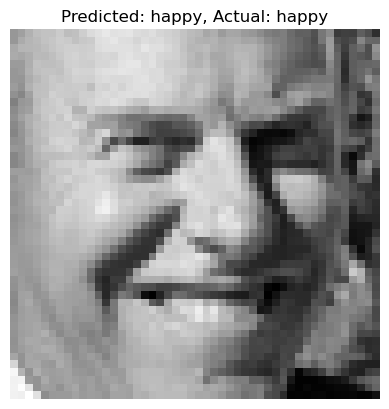

In [ ]:
# make new predictions
model.eval()
test_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)

r = randint(0, len(test_dataset) - 1)

# Select a random image from the dataset
image, label = test_dataset[r]
image = image.unsqueeze(0).to(device)

# Perform a forward pass
output = model(image)
_, predicted = torch.max(output.data, 1)

plt.figure()
plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Predicted: {emotions[predicted.item()]}, Actual: {emotions[label]}')
plt.show()

In [8]:
torch.save(model.state_dict(), './model.pth')